<a href="https://colab.research.google.com/github/reemchaaban/game_system/blob/main/data-processing/player_count_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PLAYER COUNT PREDICTION MODEL

Installing needed packages

In [1]:
!pip install workalendar --quiet
!pip install huggingface_hub transformers --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install prometheus_client --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.1 MB/s eta 0:00:00
   ━━━

Importing needed libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
from workalendar.usa import UnitedStates  # US public holidays
from datetime import datetime, timedelta
import pickle

from google.colab import drive, files, userdata
import os

import mlflow
import mlflow.tensorflow
from pyngrok import ngrok

from prometheus_client import start_http_server, Gauge, REGISTRY

import time
import threading
import psutil

from huggingface_hub import login, upload_folder

Authenticating Hugging Face, ngrok, and GitHub using tokens from Secrets

In [3]:
HF_TOKEN = userdata.get("HF_TOKEN")
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
GITHUB_PAT = userdata.get('GITHUB_PAT')

In [4]:
login(token=HF_TOKEN)

Loading dataset from drive

In [5]:
drive.mount('/content/drive')
drive_base_path = '/content/drive/My Drive/503Nproj/datasets'
file_path = os.path.join(drive_base_path, 'player_count_history.csv')
df = pd.read_csv(file_path, parse_dates=['date'])

Mounted at /content/drive


Feature engineering

In [6]:
us_holidays = holidays.US()
cal = UnitedStates()
df['is_holiday_holidays_lib'] = df['date'].apply(lambda x: int(x in us_holidays)) #holiday package detects US holidays
df['is_holiday_workalendar'] = df['date'].apply(lambda x: int(cal.is_holiday(x))) #workalendar for US holiday calendar
df['day_of_week'] = df['date'].dt.dayofweek  # i.e., monday=0, tuesday=1, ..., sunday=6

In [7]:
# target column & features
target_col = 'total players'
feature_cols = [col for col in df.columns if col not in ['date', target_col]]

Scaling

In [8]:
scaler_players = MinMaxScaler()
df[[target_col]] = scaler_players.fit_transform(df[[target_col]])  # train only on total players
with open('scaler_players.pkl', 'wb') as f:
    pickle.dump(scaler_players, f)

scaler_features = MinMaxScaler()
df[feature_cols] = scaler_features.fit_transform(df[feature_cols])
print(df.isnull().sum()) # get number of missing values
df.fillna(df.mean(), inplace=True)


date                       0
570                        0
730                        0
578080                     0
1172470                    0
                          ..
1086940                    0
total players              0
is_holiday_holidays_lib    0
is_holiday_workalendar     0
day_of_week                0
Length: 102, dtype: int64


Sequence preparation

In [10]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])  # features
        y.append(data[i + seq_length, -1])  # target variable i.e., total players
    return np.array(X), np.array(y)

seq_length = 30  # use last 30 days to predict
data = df[feature_cols].values
X, y = create_sequences(data, seq_length)

Train-Validation-Test split


In [11]:
# train-validation-test split (0.7-0.15-0.15)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}") #verify that X train & test shapes make sense
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (489, 30, 99), y_train shape: (489,)
X_test shape: (106, 30, 99), y_test shape: (106,)


Prometheus server

In [25]:
for collector in list(REGISTRY._collector_to_names.keys()):
    REGISTRY.unregister(collector)

In [16]:
def start_prometheus_server():
    start_http_server(8000)
    print("Prometheus server started on http://localhost:8000/")

threading.Thread(target=start_prometheus_server).start()

Prometheus server started on http://localhost:8000/


In [17]:
# terminate any open tunnels
ngrok.kill()

In [18]:
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
prometheus_url = ngrok.connect(8000, proto="http")

print(f" * Ngrok tunnel: {prometheus_url}")

 * Ngrok tunnel: NgrokTunnel: "https://9218-35-237-132-58.ngrok-free.app" -> "http://localhost:8000"


Metrics callback

In [12]:
mlflow.tensorflow.autolog(disable=True)

cpu_usage_metric = Gauge('cpu_usage_percent', 'CPU usage (%)')
memory_usage_metric = Gauge('memory_usage_percent', 'Memory usage (%)')
epoch_duration_metric = Gauge('epoch_duration_seconds', 'Time to complete 1 epoch')

class MLflowAndPrometheusCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEpoch {epoch} logs: {logs}\n")
        for key, value in logs.items():
            mlflow.log_metric(key, value, step=epoch)
        cpu = psutil.cpu_percent()
        mem = psutil.virtual_memory().percent
        duration = time.time() - self.epoch_start_time
        cpu_usage_metric.set(cpu)
        memory_usage_metric.set(mem)
        epoch_duration_metric.set(duration)
        print(f"Epoch {epoch}: Duration {duration:.2f}s | CPU {cpu}% | Memory {mem}%")


LSTM model training

In [13]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

with mlflow.start_run(run_name="player-count-predictor"):
    model.fit(X_train, y_train,
              epochs=30,
              batch_size=16,
              validation_data=(X_test, y_test),
              callbacks=[MLflowAndPrometheusCallback()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1447 - mae: 0.3235 - mse: 0.1447
Epoch 0 logs: {'loss': 0.13584837317466736, 'mae': 0.3115274906158447, 'mse': 0.13584837317466736, 'val_loss': 0.1483250856399536, 'val_mae': 0.32095563411712646, 'val_mse': 0.1483250856399536}

Epoch 0: Duration 7.15s | CPU 42.3% | Memory 14.0%
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.1441 - mae: 0.3228 - mse: 0.1441 - val_loss: 0.1483 - val_mae: 0.3210 - val_mse: 0.1483
Epoch 2/30
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1101 - mae: 0.2776 - mse: 0.1101
Epoch 1 logs: {'loss': 0.11538448184728622, 'mae': 0.2907589077949524, 'mse': 0.11538448184728622, 'val_loss': 0.11222474277019501, 'val_mae': 0.2912381589412689, 'val_mse': 0.11222474277019501}

Epoch 1: Duration 1.36s | CPU 88.3% | Memory 14.1%
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1104 - mae: 0.2784 - mse: 0.1104 - val_loss: 0.1122 - val_mae: 0.2912 - val_mse: 0.1122
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 37

Model evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step


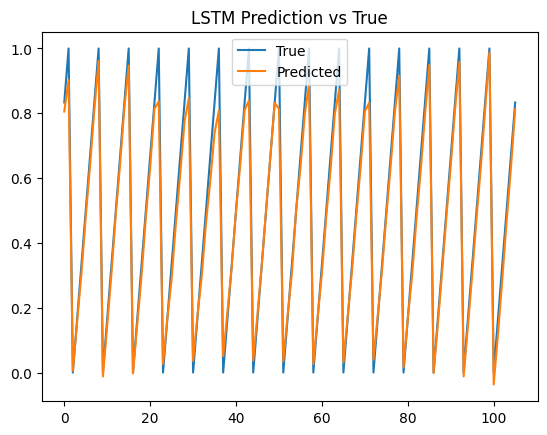

In [14]:
y_pred = model.predict(X_test)

plt.plot(np.arange(len(y_test)), y_test, label="True")
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Prediction vs True")

plt.savefig("prediction_plot.png")

Future prediction function

In [15]:
def predict_future(date):
    date = pd.to_datetime(date)
    day_of_week = date.weekday()
    is_holiday_holidays = int(date in us_holidays)
    is_holiday_workalendar = int(cal.is_holiday(date))

    last_seq = df[feature_cols].values[-seq_length:]  # ensure the shape is correct

    # ensure extra_features has same number of columns as features
    extra_features = np.zeros(len(feature_cols))  # replace null values w/ zeros
    extra_features[-3:] = [day_of_week / 6.0, is_holiday_holidays, is_holiday_workalendar]  # normalization

    # stack last_seq w/ extra_features
    last_seq = np.vstack([last_seq[1:], extra_features])  # (seq_length, num_features)

    # reshape sequence to (1, seq_length, num_features)
    last_seq = np.expand_dims(last_seq, axis=0)  # shape (1, seq_length, num_features)

    # ensure input shape matches model's expected input (99 features)
    last_seq = last_seq[:, :, :99]  # trim/select first 99 features

    # prediction
    prediction = model.predict(last_seq)

    # check inverse transformation
    predicted_players_scaled = np.array([[prediction[0][0]]])  # shape should be (1, 1)

    predicted_players = scaler_players.inverse_transform(predicted_players_scaled)[0][0]

    print(f"Predicted total players (scaled): {prediction[0][0]}")
    print(f"Predicted total players after inverse transform: {predicted_players}")

    # debugging
    print("Scaler Min:", scaler_players.data_min_)
    print("Scaler Max:", scaler_players.data_max_)

    # manual computation of inverse transformation
    min_val = scaler_players.data_min_[0]  # min value used in training
    max_val = scaler_players.data_max_[0]  # max value used in training
    predicted_manual = min_val + (max_val - min_val) * prediction[0][0]

    print("Manually-calculated inverse transform:", predicted_manual)

    # extra debugging
    print(f"Day of week (normalized): {day_of_week / 6.0}")
    print(f"Holiday feature 1: {is_holiday_holidays}")
    print(f"Holiday feature 2: {is_holiday_workalendar}")

    return predicted_players

# test w/ future date
future_date = "2025-06-21"
predict_future(future_date)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted total players (scaled): 0.4354063868522644
Predicted total players after inverse transform: 5864379.5
Scaler Min: [4719905.]
Scaler Max: [7348425.]
Manually-calculated inverse transform: 5864379.395968914
Day of week (normalized): 0.8333333333333334
Holiday feature 1: 0
Holiday feature 2: 0


np.float32(5864379.5)

Launch MLflow UI locally on port 5000

In [23]:
! pkill -f "mlflow ui"

get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

Expose using ngrok

In [24]:
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

mlflow_url = ngrok.connect(5000, proto="http")

print(f" * Ngrok tunnel: {mlflow_url}")

 * Ngrok tunnel: NgrokTunnel: "https://64a6-35-243-176-77.ngrok-free.app" -> "http://localhost:5000"


Save trained model

In [22]:
model.export("player_count_model")

Saved artifact at 'player_count_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 99), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134436259900176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259902288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259902096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259899792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259901328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259904784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259904016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259905168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259899408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134436259897872: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [28]:
upload_folder (
    repo_id="reemchaaban/player-count-prediction",
    folder_path="player_count_model",
    path_in_repo="player_count_model",
    commit_message="Initial commit from Google Colab"
)


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

fingerprint.pb:   0%|          | 0.00/55.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/126k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reemchaaban/player-count-prediction/commit/75ecf44044b171009a3cf80073d33845d4d34fcd', commit_message='Initial commit from Google Colab', commit_description='', oid='75ecf44044b171009a3cf80073d33845d4d34fcd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/reemchaaban/player-count-prediction', endpoint='https://huggingface.co', repo_type='model', repo_id='reemchaaban/player-count-prediction'), pr_revision=None, pr_num=None)

Automating update of model & scaler files in IEP1 folder after retraining

In [29]:
GITHUB_USERNAME = "reemchaaban"
GITHUB_EMAIL = "reem.chaabann@gmail.com"
REPO_NAME = "game_system"
BRANCH = "main"
TARGET_SUBDIR = "IEP1"

token = userdata.get('GITHUB_PAT')

!git config --global user.email "{GITHUB_EMAIL}"
!git config --global user.name "{GITHUB_USERNAME}"

!rm -rf {REPO_NAME}
!git clone https://{token}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git

!rm -rf {REPO_NAME}/{TARGET_SUBDIR}/model
!mkdir -p {REPO_NAME}/{TARGET_SUBDIR}/model
!ls
!cp player_count_model/fingerprint.pb {REPO_NAME}/{TARGET_SUBDIR}/model/
!cp player_count_model/saved_model.pb {REPO_NAME}/{TARGET_SUBDIR}/model/
!cp -r player_count_model/variables {REPO_NAME}/{TARGET_SUBDIR}/model/

!cp scaler_players.pkl {REPO_NAME}/{TARGET_SUBDIR}/utils/scaler_players.pkl

%cd {REPO_NAME}
!git add .
!git commit -m "Update IEP1 model and scaler from Colab"
!git push origin {BRANCH}
%cd ..

Cloning into 'game_system'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 172 (delta 24), reused 20 (delta 6), pack-reused 114 (from 1)
Receiving objects: 100% (172/172), 20.97 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (61/61), done.
drive	     mlruns		 prediction_plot.png  scaler_players.pkl
game_system  player_count_model  sample_data
/content/game_system
[main 9c8fa26] Update IEP1 model and scaler from Colab
 4 files changed, 1 insertion(+), 1 deletion(-)
 rewrite IEP1/model/variables/variables.data-00000-of-00001 (91%)
 rewrite IEP1/model/variables/variables.index (98%)
Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 2 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 1.18 MiB | 2.60 MiB/s, done.
Total 9 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed wi